In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import decoupler as dc
from anndata import AnnData

plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Arial', "figure.facecolor": 
                     'white', "axes.facecolor": 'white',
                     "savefig.facecolor": 'white'})

In [2]:
important_genes = pd.read_csv('feature_importance/Pancreatic/AUC_zscore/SHAP_important_genes.csv')
drug_genes = important_genes.pivot(columns = 'gene', values = 'shap', index = 'drug')
# swap high and low values (viability) to focus on high response instead
drug_genes = drug_genes * -1
drug_genes

gene,5S_rRNA.5,5S_rRNA.7,A1BG,AADACL4,AADAT,AAK1,AANAT,AARS1,AARSD1,AASDH,...,ZSWIM4,ZSWIM6,ZSWIM8-AS1,ZWILCH,ZWINT,ZXDA,ZXDB,ZYG11A,ZZEF1,ZZZ3
drug,,,,,,,,,,,,,,,,,,,,,
5-FU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afatinib,NaN,NaN,0.00054,NaN,NaN,NaN,NaN,NaN,0.000673,NaN,...,0.000259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bortezomib,NaN,NaN,NaN,-0.000396,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002443,0.001303
Celecoxib,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Disulfuram,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001768,...,NaN,NaN,NaN,-0.000519,NaN,NaN,NaN,NaN,NaN,NaN
Everolimus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gemcitabine,NaN,NaN,-0.00457,NaN,-0.000527,NaN,NaN,NaN,NaN,NaN,...,-0.000732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
K-ras(G12C) Inhibitor 9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KU-55933,NaN,NaN,NaN,NaN,-0.000780,NaN,NaN,NaN,NaN,NaN,...,0.001153,NaN,NaN,NaN,NaN,0.000749,0.000782,NaN,NaN,NaN


In [67]:
progeny = dc.get_progeny(top=300)
drug_pathways = {}

dorothea = dc.get_dorothea()
drug_tf = {}

shared_progeny = list(set(progeny.target) & set(drug_genes.columns))
drug_genes_progeny = drug_genes[shared_progeny]

shared_dorothea = list(set(dorothea.target) & set(drug_genes.columns))
drug_genes_dorothea = drug_genes[shared_dorothea]

for drug in drug_genes.index.tolist():
    print(drug)
    drug_row = drug_genes.loc[drug].dropna().to_frame().T
    
    try:
        pathway_acts, pathway_pvals = dc.run_consensus(mat=drug_row, net=progeny, min_n = 3)
        drug_pathways[drug] = (pathway_acts, pathway_pvals)
    except Exception as e:
        print('Pathways:', e)
    
    try:
        tf_acts, tf_pvals = dc.run_consensus(mat=drug_row, net=dorothea, min_n = 3)
        drug_tf[drug] = (tf_acts, tf_pvals)
    except Exception as e:
        print('TF:', e)

5-FU
Afatinib
Bortezomib
Celecoxib
Pathways: No sources with more than min_n=3 targets. Make sure mat and net have shared target features or
        reduce the number assigned to min_n
TF: No sources with more than min_n=3 targets. Make sure mat and net have shared target features or
        reduce the number assigned to min_n
Disulfuram
Everolimus
Gemcitabine
K-ras(G12C) Inhibitor 9
KU-55933
LY2874455
Lapatinib
MK-2206
Nutlin-3
OSI-420
Olaparib
Oxaliplatin
Paclitaxel
Ruxolitinib
SB5225334
SF1670
SGI-1776
SN-38
Selumetinib
Sunitinib
TPCA-1
WIKI4
Pathways: No sources with more than min_n=3 targets. Make sure mat and net have shared target features or
        reduce the number assigned to min_n


5-FU
Afatinib
Bortezomib
Celecoxib
Disulfuram
Everolimus
Gemcitabine
K-ras(G12C) Inhibitor 9


/Users/katja/miniconda3/lib/python3.9/site-packages/decoupler/plotting.py:355: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)


KU-55933
LY2874455
Lapatinib
MK-2206
Nutlin-3
OSI-420
Olaparib
Oxaliplatin
Paclitaxel
Ruxolitinib
SB5225334
SF1670
SGI-1776
SN-38
Selumetinib
Sunitinib
TPCA-1
WIKI4


<Figure size 432x288 with 0 Axes>

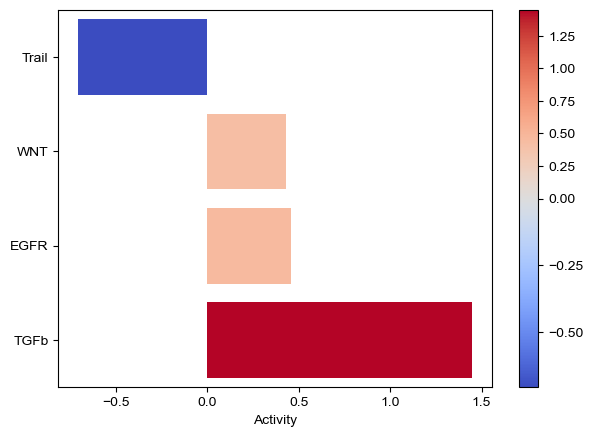

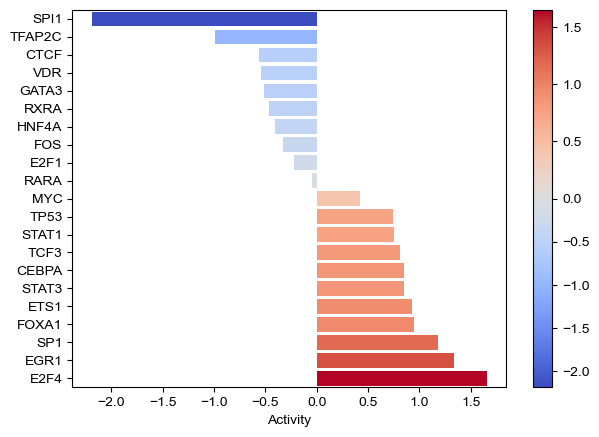

<Figure size 432x288 with 0 Axes>

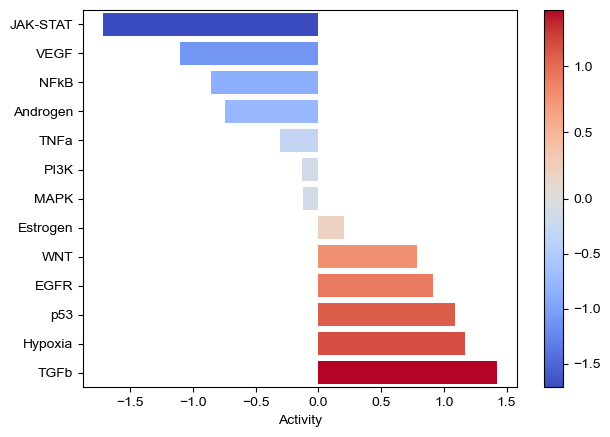

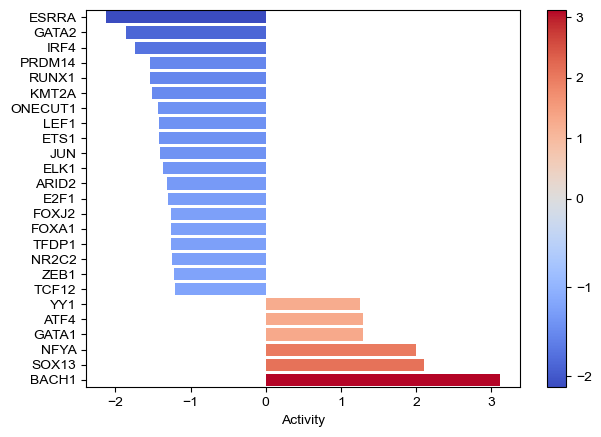

<Figure size 432x288 with 0 Axes>

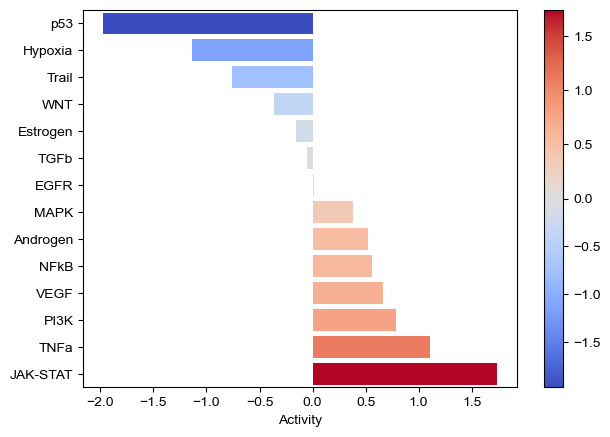

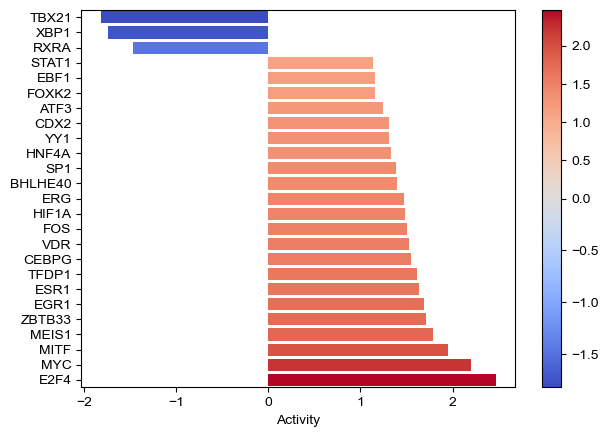

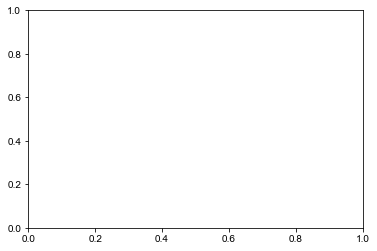

<Figure size 432x288 with 0 Axes>

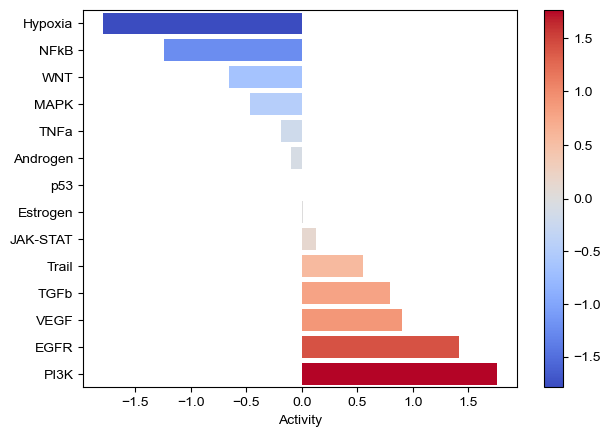

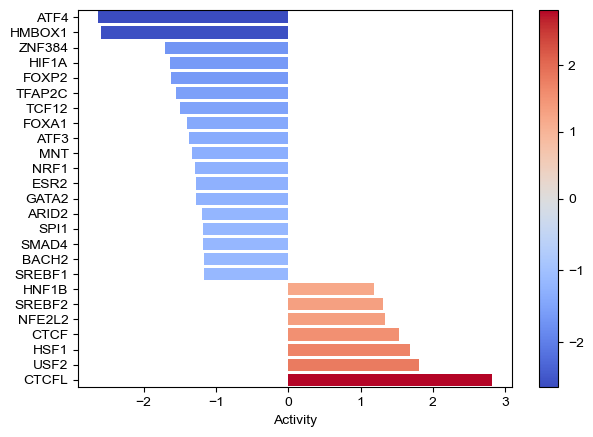

<Figure size 432x288 with 0 Axes>

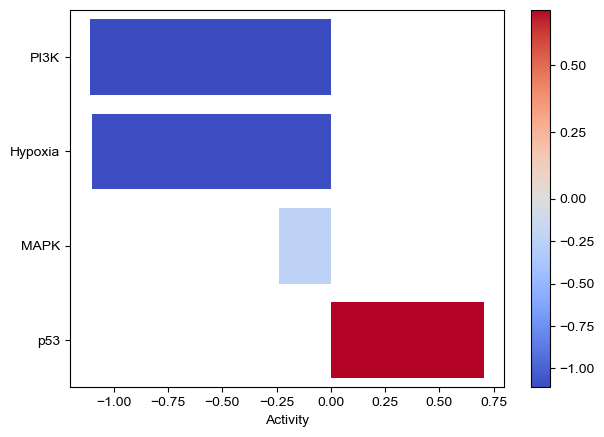

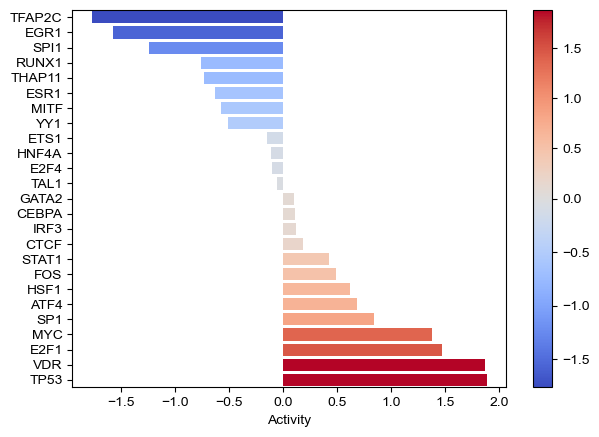

<Figure size 432x288 with 0 Axes>

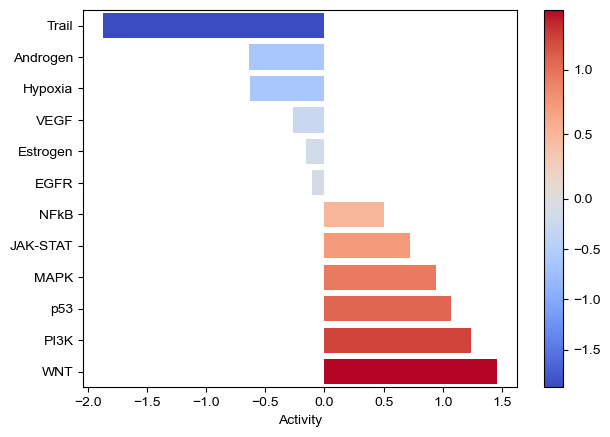

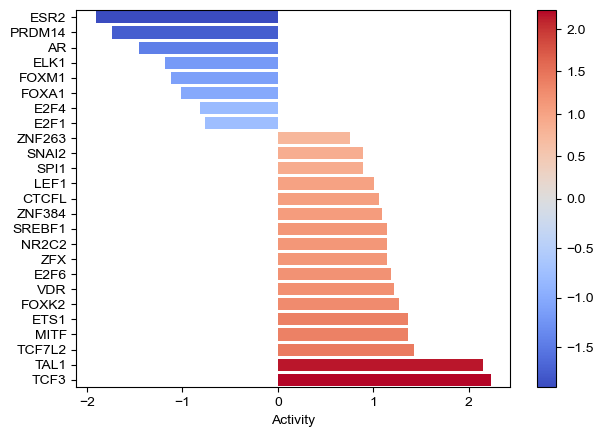

<Figure size 432x288 with 0 Axes>

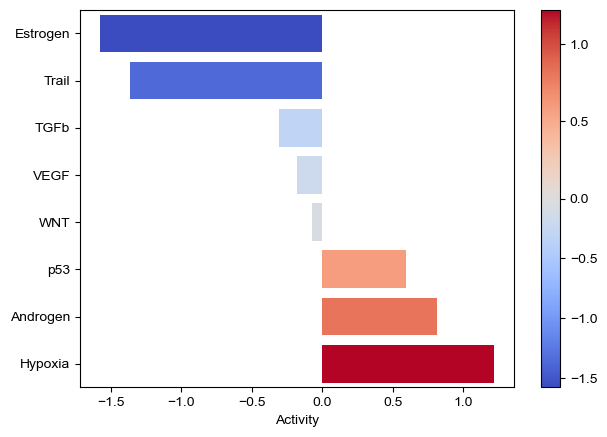

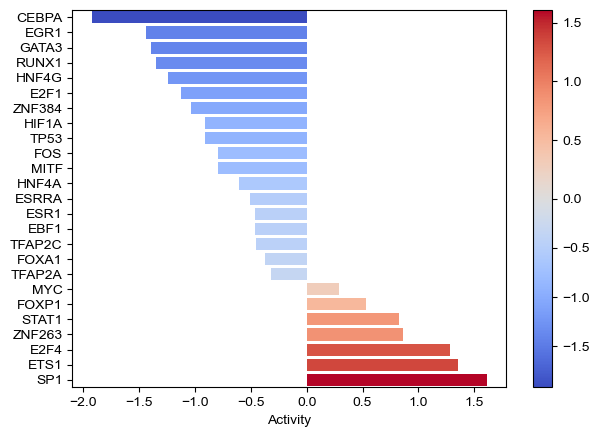

<Figure size 432x288 with 0 Axes>

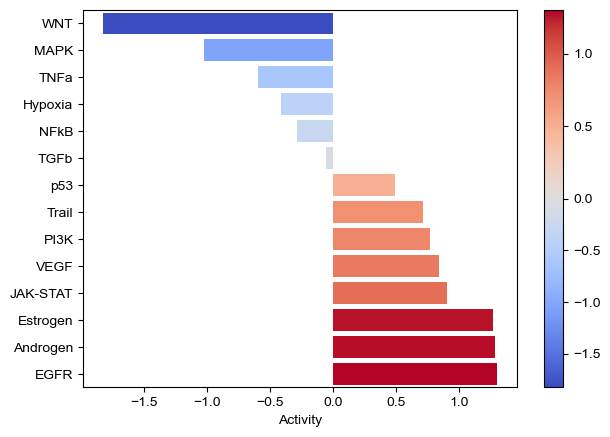

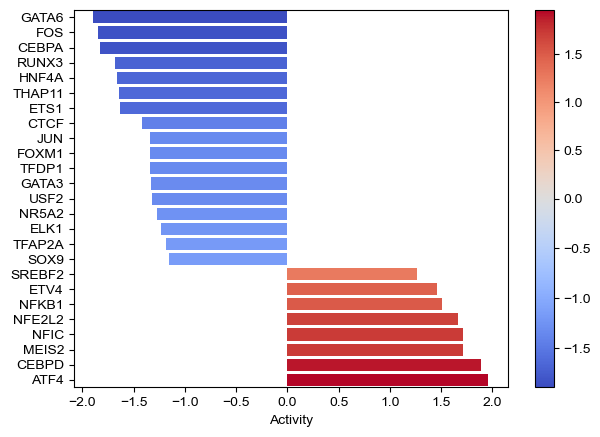

<Figure size 432x288 with 0 Axes>

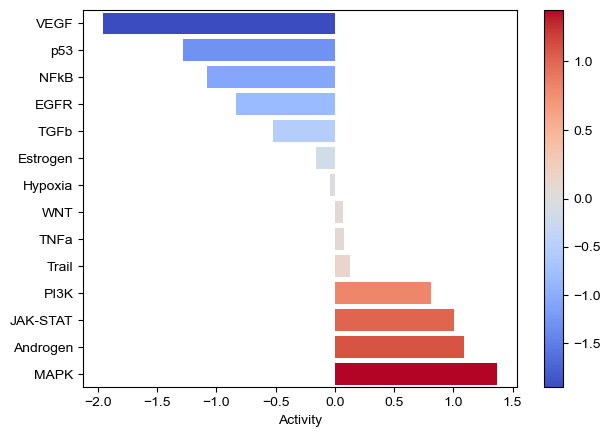

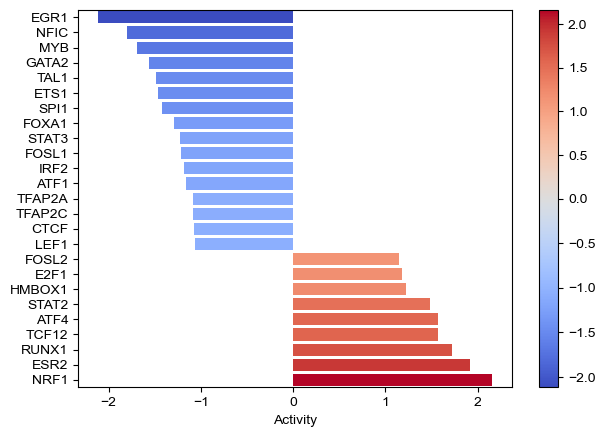

<Figure size 432x288 with 0 Axes>

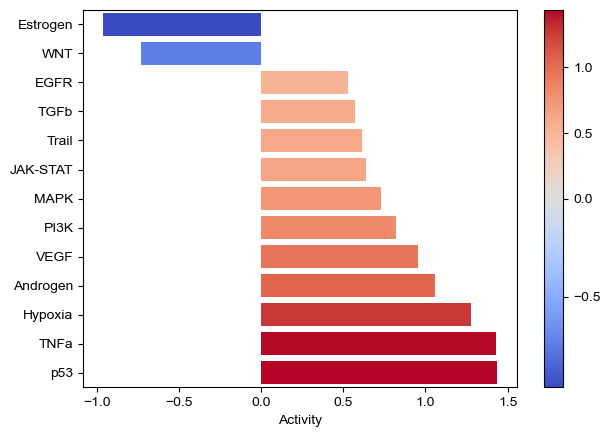

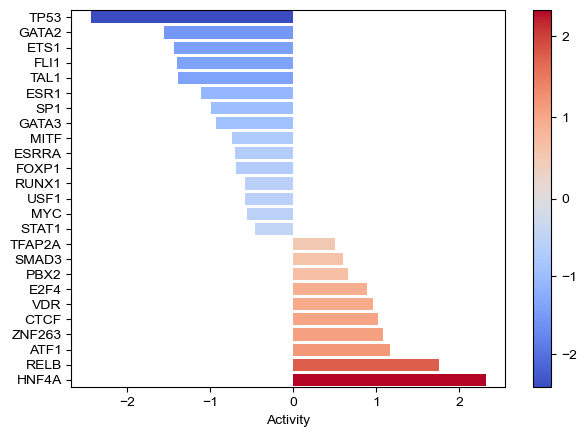

<Figure size 432x288 with 0 Axes>

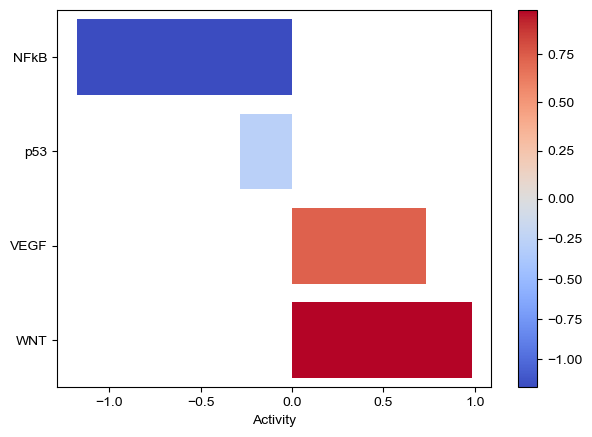

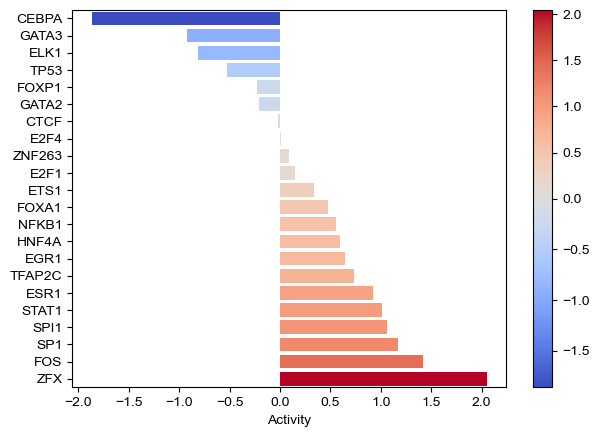

<Figure size 432x288 with 0 Axes>

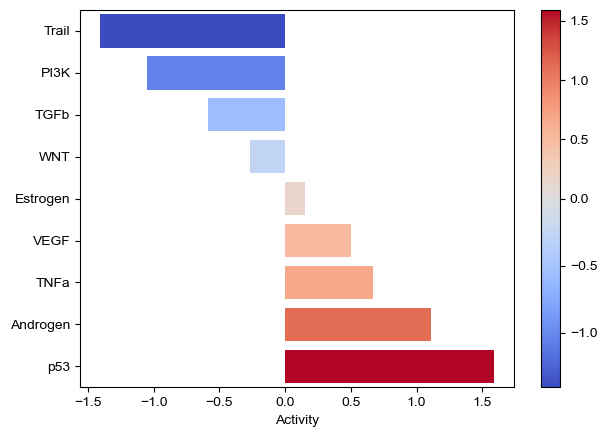

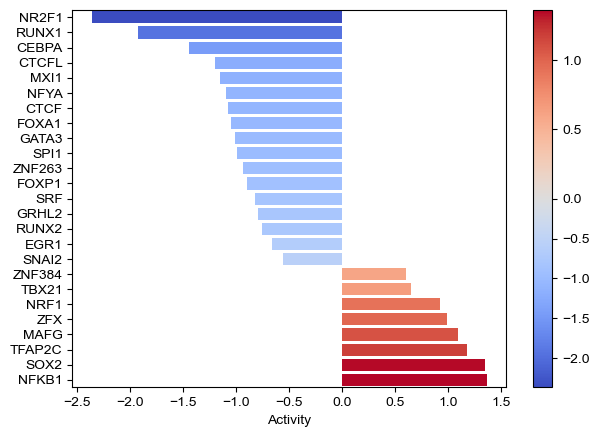

<Figure size 432x288 with 0 Axes>

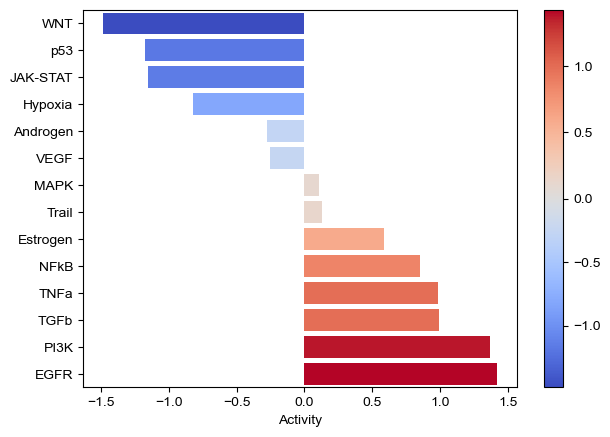

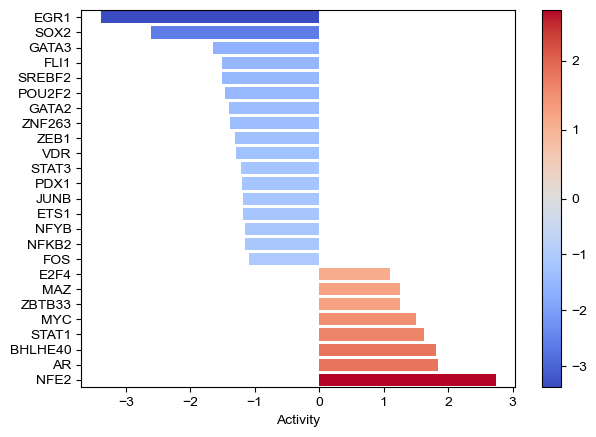

<Figure size 432x288 with 0 Axes>

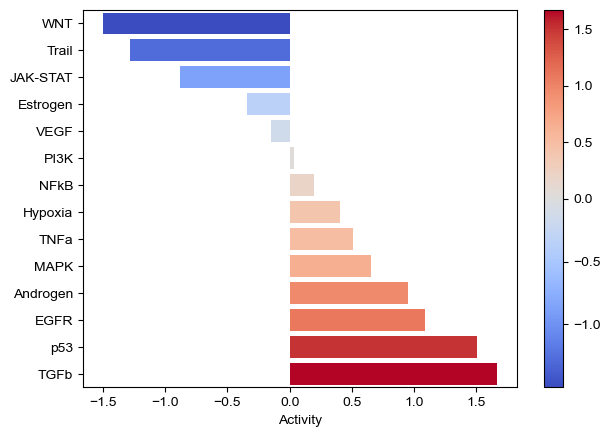

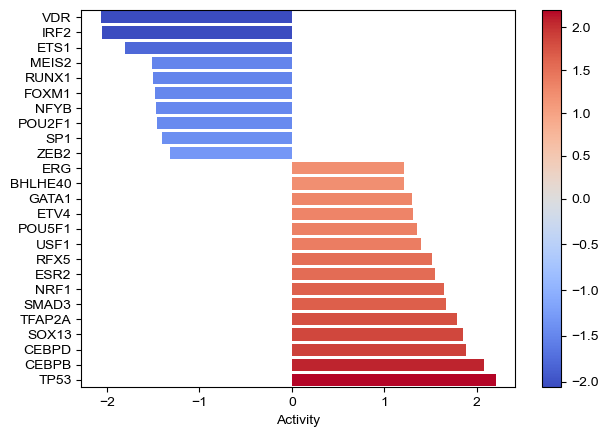

<Figure size 432x288 with 0 Axes>

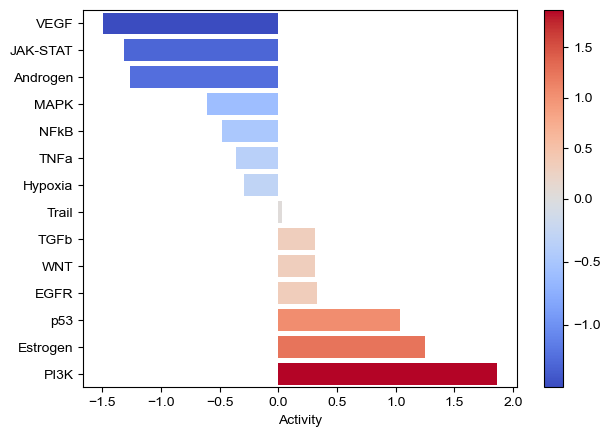

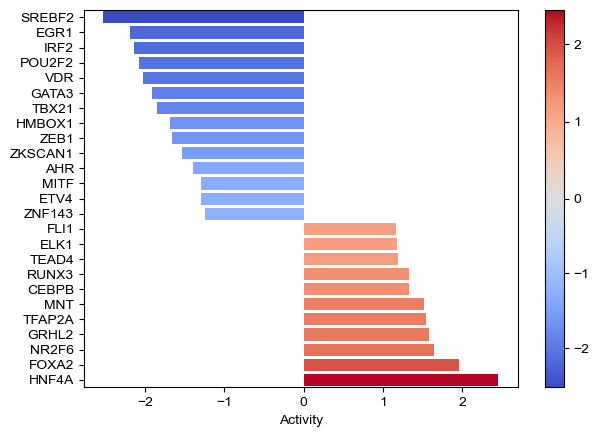

<Figure size 432x288 with 0 Axes>

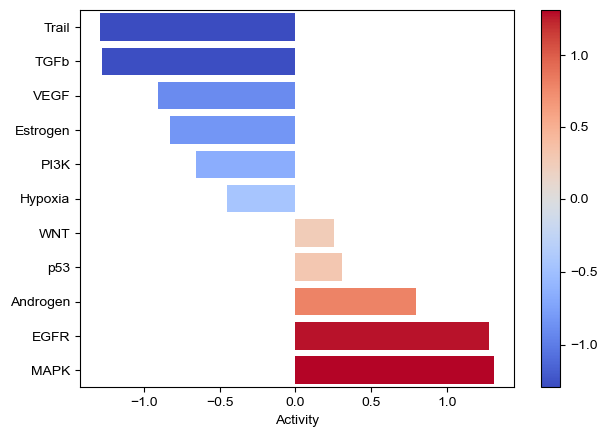

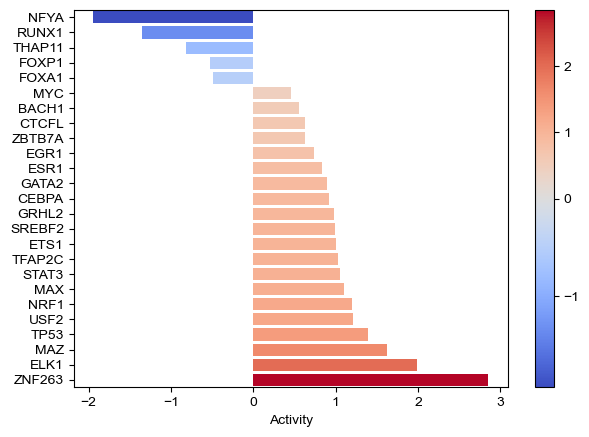

<Figure size 432x288 with 0 Axes>

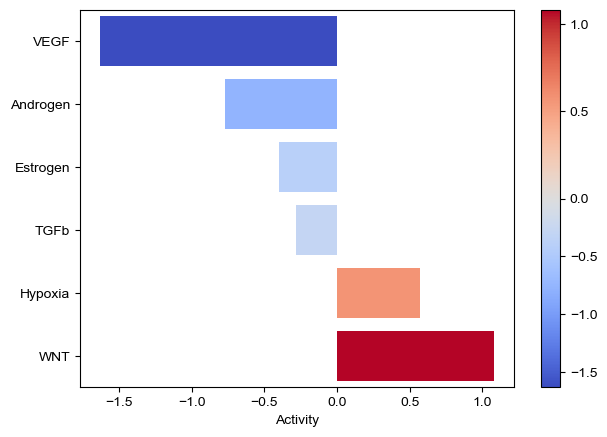

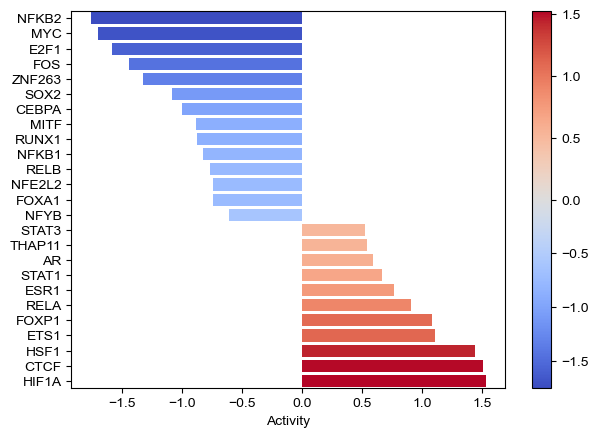

<Figure size 432x288 with 0 Axes>

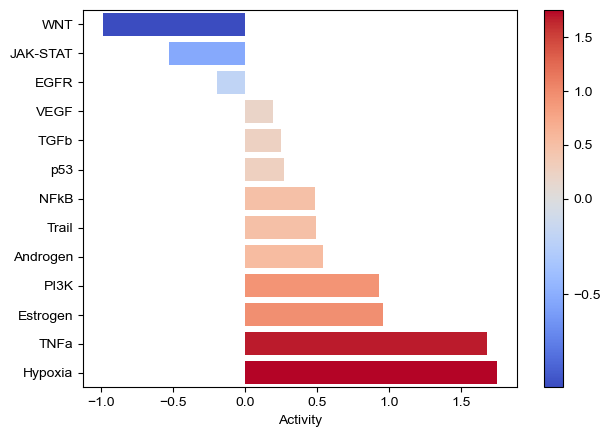

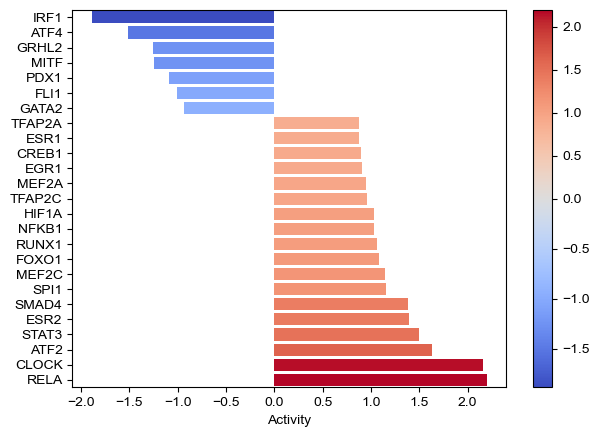

<Figure size 432x288 with 0 Axes>

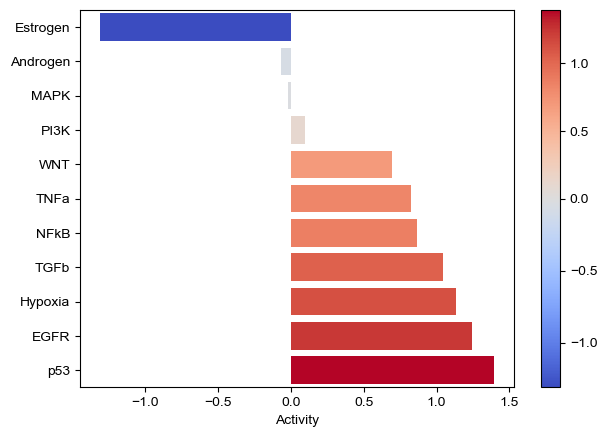

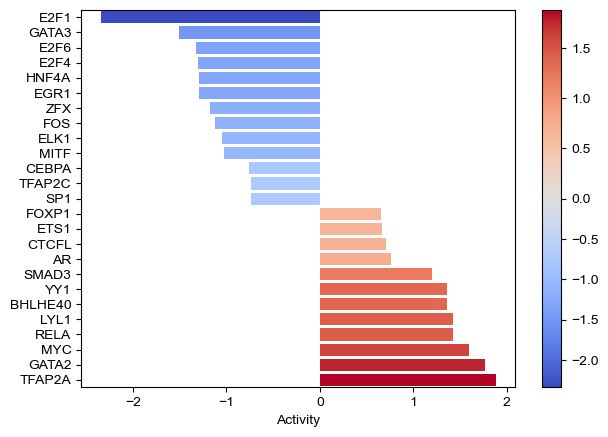

<Figure size 432x288 with 0 Axes>

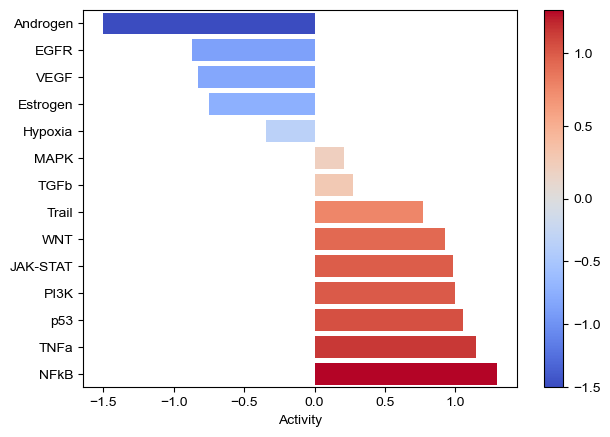

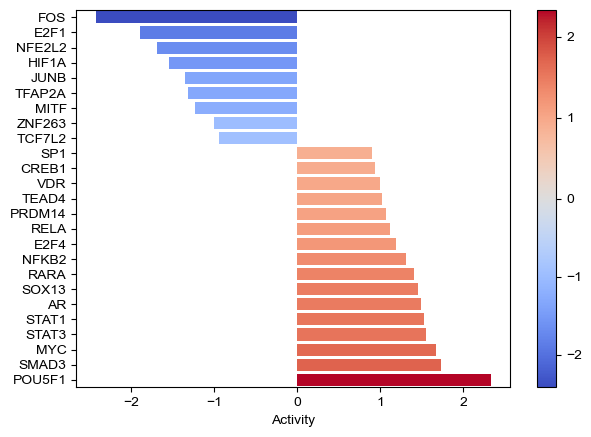

<Figure size 432x288 with 0 Axes>

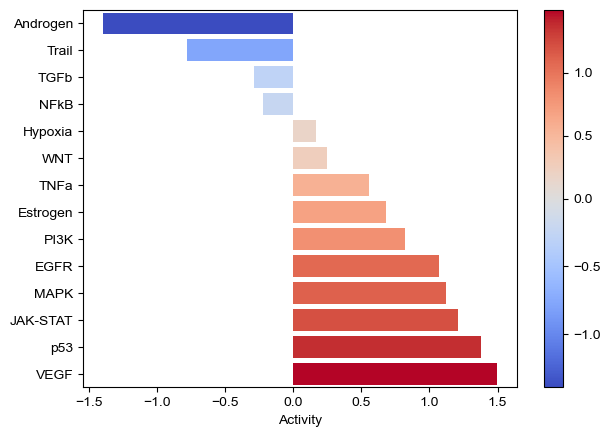

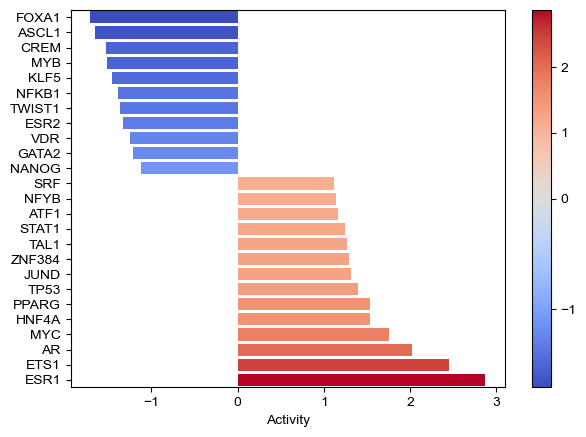

<Figure size 432x288 with 0 Axes>

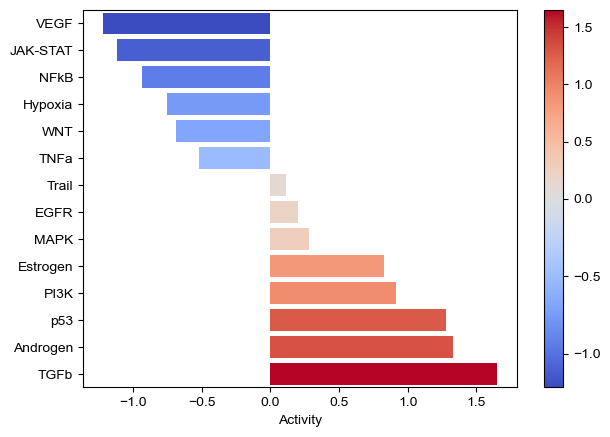

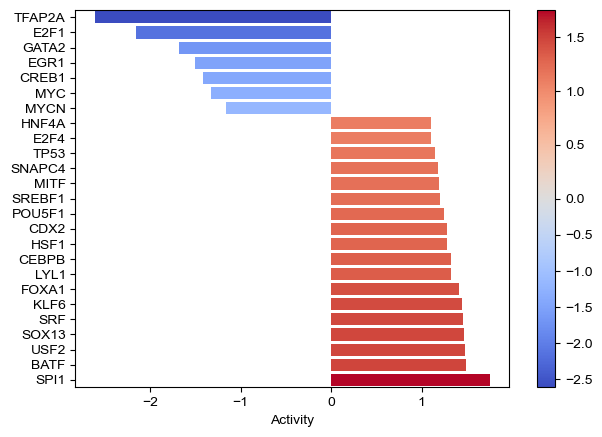

<Figure size 432x288 with 0 Axes>

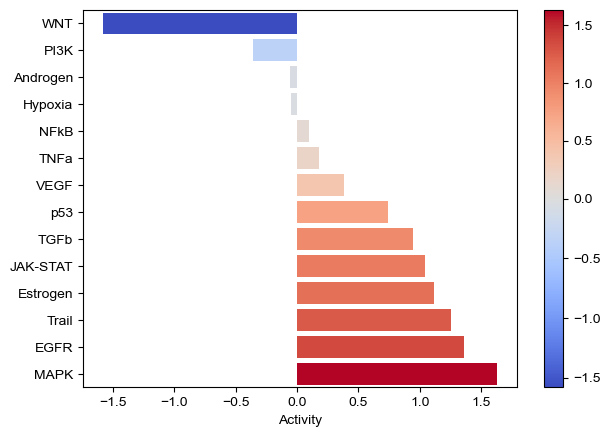

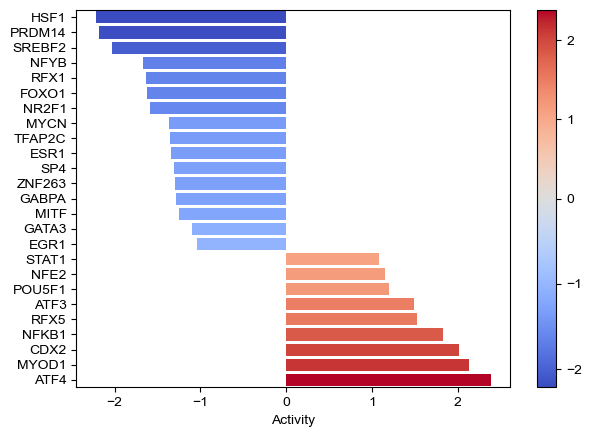

<Figure size 432x288 with 0 Axes>

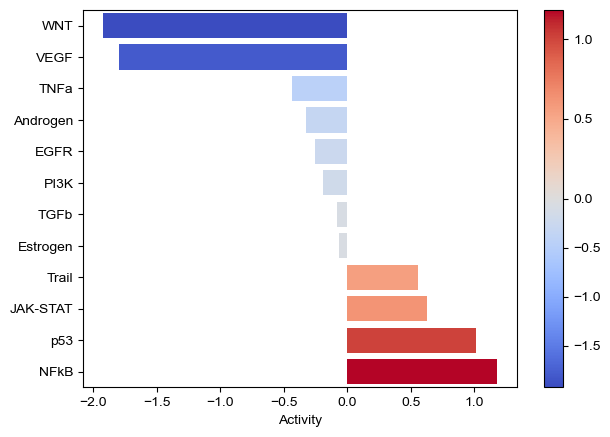

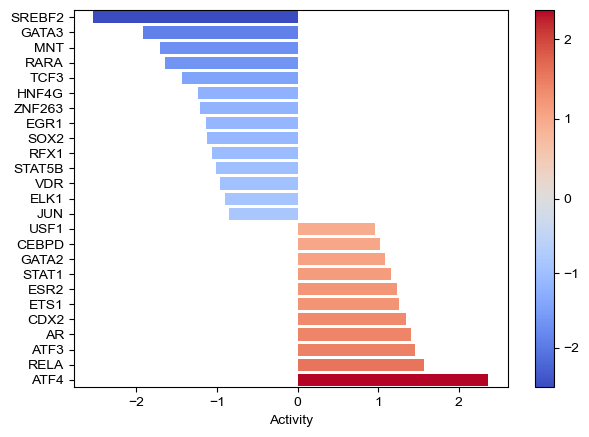

<Figure size 432x288 with 0 Axes>

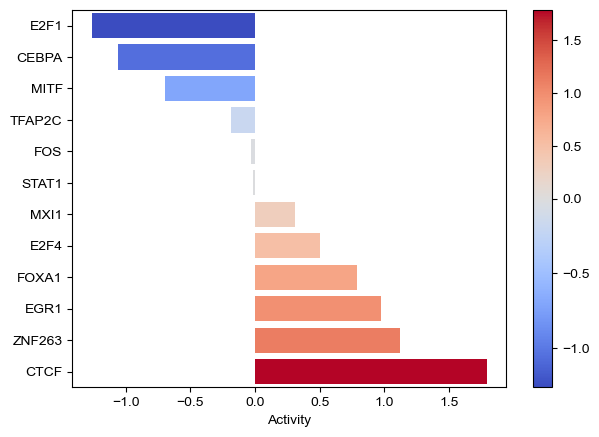

In [77]:
out_folder = 'feature_importance/Pancreatic/AUC_zscore/'
for drug in drug_genes.index.tolist():
    print(drug)
    fig, ax = plt.subplots()
    
    if drug in drug_pathways:
        if drug in drug_pathways:
            #plt.title(drug+ ' model importance pathways')
            dc.plot_barplot(drug_pathways[drug][0].dropna(axis = 1), 
                            drug, top=25, vertical=True, 
                                 return_fig=True, save = os.path.join(out_folder, 'pathways/'+drug+'_model_importance_pathways.png'))
            fig.clear()
    if drug in drug_tf:
        #plt.title(drug+ ' model importance transcription factor activity')
        dc.plot_barplot(drug_tf[drug][0].dropna(axis = 1), drug, top=25, vertical=True, return_fig=True,
                            save = os.path.join(out_folder, 'transcription_factor_activity/'+drug+'_model_importance_TF.png'))
        #fig.savefig(os.path.join(out_folder, 'transcription_factor_activity/'+drug+'_response_TF.png'))
        fig.clear()